In [1]:
import pandas as pd
import pandas_ta as ta

In [2]:
# Load data
df=pd.read_csv("EURUSD_Candlestick_1_D_BID_01.01.2011-08.06.2024.csv")

In [3]:
df["Gmt time"]=df["Gmt time"].str.replace(".000","")
df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%d.%m.%Y %H:%M:%S')
#df.set_index("Gmt time", inplace=True)
df=df[df.High!=df.Low]
df.reset_index(inplace=True, drop=True)

In [4]:
df['emafast'] = df.ta.ema(length=30)
df['emaslow'] = df.ta.ema(length=60)

In [5]:
def TotalSignal(df, emafast, emaslow):
    df['TotalSignal'] = 0
    for row in range(1, len(df)):
        if (emafast[row-1] <= emaslow[row-1]) and (emafast[row] > emaslow[row]):
            df.at[row, 'TotalSignal'] = 2
        elif (emafast[row-1] >= emaslow[row-1]) and (emafast[row] < emaslow[row]):
            df.at[row, 'TotalSignal'] = 1
    return df
        
TotalSignal(df, emafast=df.emafast, emaslow=df.emaslow)

,Gmt time,Open,High,Low,Close,Volume,emafast,emaslow,TotalSignal
0,2011-01-02,1.33674,1.33696,1.33235,1.33557,19990.5703,NaN,NaN,0
1,2011-01-03,1.33560,1.33947,1.32500,1.33551,157568.2031,NaN,NaN,0
2,2011-01-04,1.33566,1.34298,1.32923,1.33179,204002.5625,NaN,NaN,0
3,2011-01-05,1.33181,1.33248,1.31262,1.31556,192261.7031,NaN,NaN,0
4,2011-01-06,1.31556,1.31698,1.29723,1.29787,175000.0625,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...
4197,2024-06-03,1.08526,1.09098,1.08278,1.09071,173492.4900,1.081873,1.080399,0
4198,2024-06-04,1.09072,1.09160,1.08590,1.08817,181035.8000,1.082279,1.080654,0
4199,2024-06-05,1.08816,1.08915,1.08544,1.08739,154652.6701,1.082609,1.080875,0
4200,2024-06-06,1.08738,1.09020,1.08619,1.08916,156122.8500,1.083031,1.081146,0


In [6]:
import numpy as np
def pointposbreak(x):
    if x['TotalSignal']==1:
        return x['High']+1e-3
    elif x['TotalSignal']==2:
        return x['Low']-1e-3
    else:
        return np.nan

df['pointposbreak'] = df.apply(lambda row: pointposbreak(row), axis=1)

In [7]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

dfpl = df[300:700]
dfpl.reset_index(inplace=True)
fig = go.Figure(data=[go.Candlestick(x=dfpl.index,
                open=dfpl['Open'],
                high=dfpl['High'],
                low=dfpl['Low'],
                close=dfpl['Close'],
                increasing=dict(line=dict(color='rgba(0, 255, 0, 0.6)', width=0.1), # Red with transparency for increasing
                fillcolor='rgba(0, 255, 0, 0.6)'),  # Match fill color with line color
                decreasing=dict(line=dict(color='rgba(255, 0, 0, 0.6)', width=0.1), # Green with transparency for decreasing
                fillcolor='rgba(255, 0, 0, 0.6)')), # Match fill color with line color),
                go.Scatter(x=dfpl.index, y=dfpl.emafast, line=dict(color='yellow', width=2), name="EMAFast"),
                go.Scatter(x=dfpl.index, y=dfpl.emaslow, line=dict(color='magenta', width=2), name="EMASlow")])

fig.add_scatter(x=dfpl.index, y=dfpl['pointposbreak'], mode="markers",
                marker=dict(size=10, color="MediumPurple"),
                name="Signal")

fig.update_layout(
    width=1000,
    height=800,
    sliders=[],
    paper_bgcolor='black',  # Set the background color of the entire figure
    plot_bgcolor='black',   # Set the background color of the plotting area
    xaxis_showgrid=False,   # Remove x-axis gridlines
    yaxis_showgrid=False,   # Remove y-axis gridlines
)

fig.show()

In [8]:
dfpl = df[:].copy()

In [9]:
from backtesting import Strategy, Backtest
import pandas_ta as ta

dfpl["EMAFast"] = ta.ema(dfpl["Close"], length=5)
dfpl["EMASlow"] = ta.ema(dfpl["Close"], length=20)

def SIGNAL():
    return dfpl.TotalSignal

class MyStrat(Strategy):
    fast_ema_len = 5
    slow_ema_len = 20
    mysize = 0.1

    def init(self):
        dfpl["EMAFast"] = ta.ema(dfpl["Close"], length=self.fast_ema_len)
        dfpl["EMASlow"] = ta.ema(dfpl["Close"], length=self.slow_ema_len)
        self.fast_ema = self.I(lambda: dfpl["EMAFast"])
        self.slow_ema = self.I(lambda: dfpl["EMASlow"])

    def next(self):
        if self.fast_ema[-1] > self.slow_ema[-1] and self.fast_ema[-2] <= self.slow_ema[-2]:
            for trade in self.trades:
                if trade.is_short:
                    trade.close()
            if len(self.trades) == 0:
                self.buy(size=self.mysize)

        elif self.fast_ema[-1] < self.slow_ema[-1] and self.fast_ema[-2] >= self.slow_ema[-2]:
            for trade in self.trades:
                if trade.is_long:
                    trade.close()
            if len(self.trades) == 0:
                self.sell(size=self.mysize)

bt = Backtest(dfpl, MyStrat, cash=100000, margin=1/10, commission=.000)
stats, heatmap = bt.optimize(fast_ema_len=range(5, 100, 5),
                    slow_ema_len=range(40, 200, 10),
                    maximize='Return [%]', max_tries=400,
                    random_state=0,
                    return_heatmap=True)
stats

/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

/var/folders/gz/19tbysb56gjdnsx4fvxvfflh0000gn/T/ipykernel_71495/2044448718.py:36: UserWarning:

Data index is not datetime. Assuming simple periods, but `pd.DateTimeIndex` is advised.

/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/backtesting/backtesting.py:1488: UserWarning:

Searching for best of 304 configurations.

/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/backtesting/backtesting.py:1375: UserWarning:

For multiprocessing support in `Backtest.optimize()` set multiprocessing start method to 'fork'.



Start                                     0.0
End                                    4201.0
Duration                               4201.0
Exposure Time [%]                   54.593051
Equity Final [$]                 125489.36734
Equity Peak [$]                   141439.7621
Return [%]                          25.489367
Buy & Hold Return [%]              -19.122921
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     NaN
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              0.0
Max. Drawdown [%]                  -11.410239
Avg. Drawdown [%]                    -1.87258
Max. Drawdown Duration                 1421.0
Avg. Drawdown Duration              91.186047
# Trades                                  9.0
Win Rate [%]                        55.555556
Best Trade [%]                      17.276575
Worst Trade [%]                     -3.331522
Avg. Trade [%]                    

Matplotlib is building the font cache; this may take a moment.


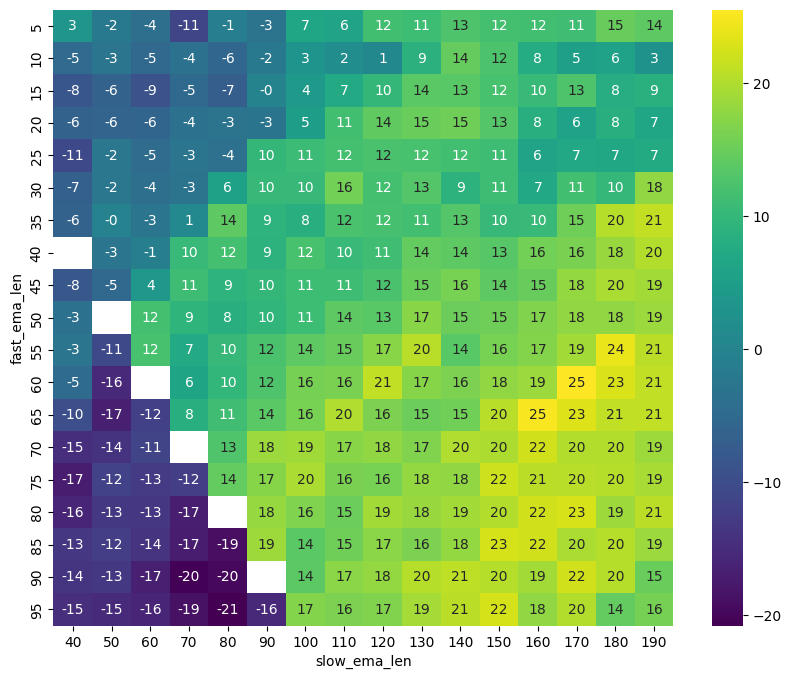

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Convert multiindex series to dataframe
heatmap_df = heatmap.unstack()
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_df, annot=True, cmap='viridis', fmt='.0f')
plt.show()

In [11]:
bt.plot()

/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_drag' property; using the latest value

/Users/sami/code/stock_analysis/env/lib/python3.9/site-packages/backtesting/_plotting.py:659: UserWarning:

found multiple competing values for 'toolbar.active_scroll' property; using the latest value



GridPlot(id='p1301', ...)